In [ ]:
from __future__ import print_function

import tensorflow_datasets as tfds
import tensorflow as tf


from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

import pandas as pd

In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json

#### Applications:
    
    The main goal of RNN is to solve sequence learning problems. 
    
    1. Sentiment Analysis (with and without pre-trained embeddings)
    2. Machine Translation
    3. Text Generation
    4. Timeseries Problems

#### LSTM/GRU  Input Shape

    LSTM/GRU Layer only accepts only input shape  of 3D tensor, with shape [batch, timesteps, feature].
    
    Batch: One sequence is one sample. A batch is comprised of one or more samples.
    Time Steps: One time step is one point of observation in the sample.
    Features: One feature is one observation at a time step.
    
    
    
timesteps => *The number of time steps is equal to the number of LSTM cells*

features => *The features is equal to the number of features in the dataset.*

The batch_size in the 3D tensor of the shape [batch_size, timesteps, input_dim] may not need to be specified and can be specified just to speed up the training process.

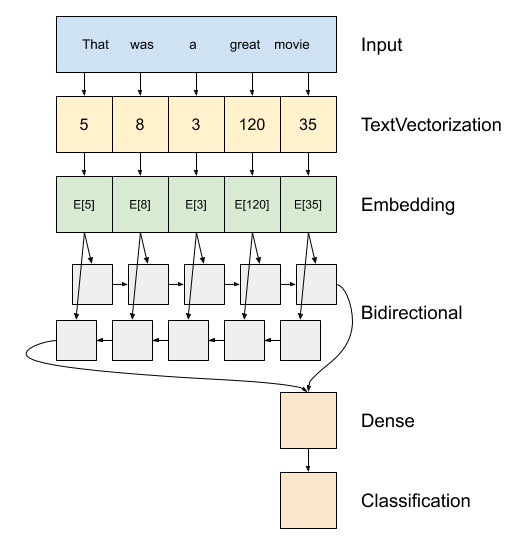

In [ ]:
# [batch, timesteps, features] 
inputs = tf.random.normal([1, 2, 2])
print(inputs.shape, "\n")

# LSTM Architectures => ManyToOne, ManyToMany

# ManyToOne
# return_sequences => Boolean. Whether to return the last output. in the output sequence, or the full sequence. 
#                     Default: False.
lstm = tf.keras.layers.LSTM(units=4)
output = lstm(inputs)
print(output.shape, "\n")

# ManyToMany
# return_sequences => Boolean. Whether to return the last output. in the output sequence, or the full sequence. 
#                     Default: False.
lstm = tf.keras.layers.LSTM(units=4, return_sequences=True)
output = lstm(inputs)
print(output.shape)

#### Padding

    When processing sequence data, it is very common for individual samples to have different lengths. Consider the following example (text tokenized as words)
    
    The data is a 2D list where individual samples have length 6, 5, and 3 respectively. Since the input data for a 
    deep learning model must be a single tensor (of shape e.g. (batch_size, 6, vocab_size) in this case), samples 
    that are shorter than the longest item need to be padded with some placeholder value (alternatively, one might 
    also truncate long samples before padding short samples).

In [ ]:
# During training, we want to process mini batch, So we need same input length with in a batch. 
[
  ["The", "weather", "will", "be", "nice", "tomorrow"],
  ["How", "are", "you", "doing", "today"],
  ["Hello", "world", "!"]
]

# Now assume that, After vocabulary lookup
raw_inputs = [
  [73, 8, 3215, 55, 927],
  [83, 91, 1, 645, 1253, 927, 890],
  [711, 632, 71]
]


padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs, padding='post')
print(padded_inputs)

#### Masking 

    Now that all samples have a uniform length, the model must be informed that some part of the data is actually 
    padding and should be ignored. That mechanism is masking
    
    "Masking" is how layers are able to know when to skip / ignore certain timesteps in sequence inputs.
    

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
masked_output = embedding(padded_inputs)

print(masked_output._keras_mask)

As you can see from the printed result, the mask is a 2D boolean tensor with shape (batch_size, sequence_length), where each individual False entry indicates that the corresponding timestep should be ignored during processing.

#### Sentiment Analysis

##### *Load Dataset*

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

In [ ]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))


sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

# Decode Example:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

#### Prepare Data for Training

Understand how to structure the data for LSTM

In [ ]:
A = (tf.data.Dataset.range(1, 5).map(lambda x: tf.fill([x], x)))

print("Original Data")
for element in A.as_numpy_iterator():
    print(element)
    
print("\n After Padding with custom padded_shape")
    
B = A.padded_batch(2, padded_shapes=5)
for element in B.as_numpy_iterator():
    print(element)
    
print("\n After Padding without custom padded_shape")
    
B = A.padded_batch(2)
for element in B.as_numpy_iterator():
    print(element)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = (train_examples.take(10000).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None],[])))
test_dataset = (test_examples.padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

#### Create Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

#### Train & Evaluate

In [ ]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

In [ ]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

# predict on a sample text without padding.
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)


# predict on a sample text with padding
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')

predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

#### ADD More Layers & Regularization

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


history1 = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)


# predict on a sample text with padding
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)